In [1]:
%cd /content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/10. 머신러닝 딥러닝/homework

/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/10. 머신러닝 딥러닝/homework


In [2]:
!unzip -qq santa.zip

replace test/normal/552.not-a-santa.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [3]:
import os
import shutil
import random
import torch
import glob
import numpy as np
from torch.utils.data import Subset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torchvision.models import vgg19, VGG19_Weights
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from PIL import Image
from torch.utils.data import SubsetRandomSampler

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [6]:
train_dataset = ImageFolder('/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/10. 머신러닝 딥러닝/homework/train', transform=transform)
val_dataset = ImageFolder('/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/10. 머신러닝 딥러닝/homework/val', transform=transform)

In [7]:
print(len(train_dataset))
print(len(val_dataset))

895
267


In [8]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, )
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2, )

In [9]:
imgs, labels = next(iter(train_loader))

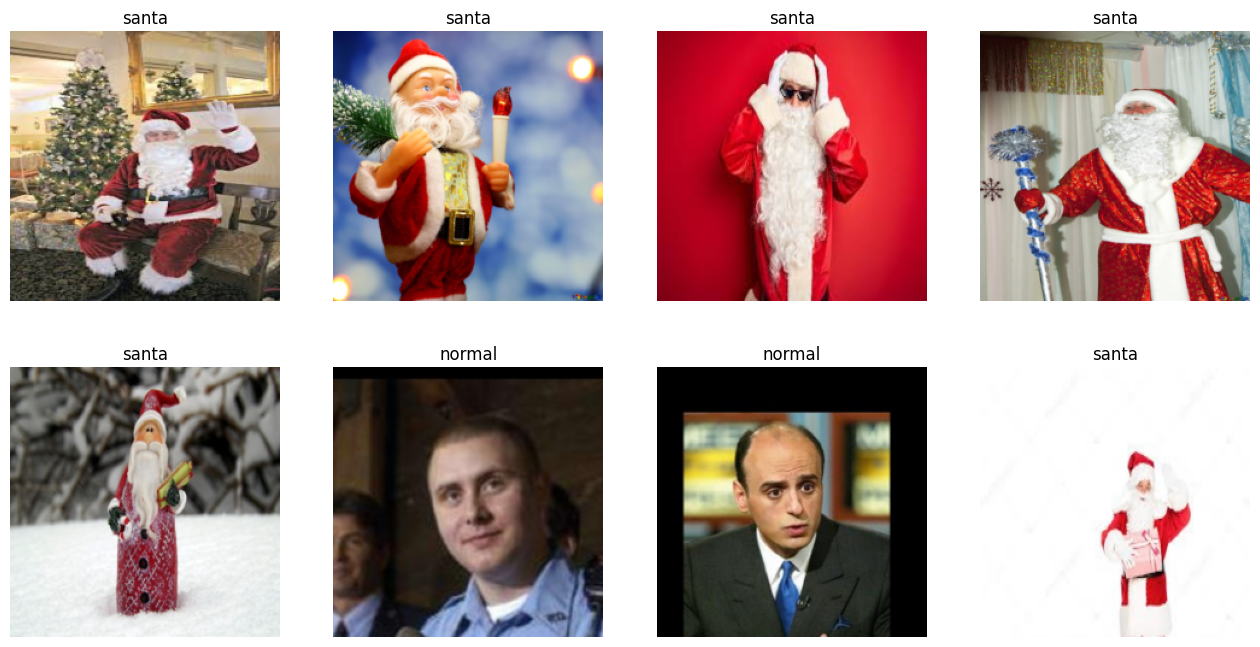

In [10]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
class_map = {0:"normal", 1:"santa"}
for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1,2,0))
    ax.set_title(class_map[label.item()])
    ax.axis('off')

In [11]:
from torch.nn.modules import padding
from torch.nn.modules.dropout import Dropout
from torch.nn.modules.pooling import MaxPool2d

In [12]:
class VGG19(nn.Module):
    def __init__(self):
        super(VGG19, self).__init__()

        self.flatten = nn.Flatten()

        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=(3, 3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=(3, 3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64,128,kernel_size=(3, 3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=(3, 3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=1000, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        output = self.classifier(x)
        return output

In [13]:
model = VGG19().to(device)
model

VGG19(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(2

In [14]:
pretrained = vgg19(weights=VGG19_Weights.IMAGENET1K_V1)

In [15]:
model.load_state_dict(pretrained.state_dict())

<All keys matched successfully>

In [16]:
for param in model.parameters():
    param.requires_grad = False

In [17]:
model.classifier[6] = nn.Linear(4096, 2)
model.classifier[6].requires_grad = True

In [18]:
criterion = nn.CrossEntropyLoss()

In [38]:
import time

def train_model(optimizer_name, model, train_loader, val_loader, criterion, num_epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    if optimizer_name == "SGD":
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
    elif optimizer_name == "RAdam":
        optimizer = optim.RAdam(model.parameters(), lr=0.01, betas=(0.9, 0.999))
    else:
        raise ValueError(f"알 수 없는 optimizer: {optimizer_name}")

    train_losses = []
    val_losses = []
    val_accuracies = []

    total_start = time.time()   # 전체 학습 시작 시간

    for epoch in range(num_epochs):
        epoch_start = time.time()   # 에포크 시작 시간

        model.train()
        running_loss = 0.0

        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # 매 에포크마다 평균 학습 손실 계산
        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # 검증 손실 계산
        val_loss = 0.0
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        val_accuracy = 100 * correct / total
        val_accuracies.append(val_accuracy)

        epoch_time = time.time() - epoch_start   # 에포크 소요 시간

        print(f'[{optimizer_name}] Epoch {epoch + 1}/{num_epochs} '
              f'| Train Loss: {train_loss:.6f} '
              f'| Val Loss: {val_loss:.6f} '
              f'| Val Acc: {val_accuracy:.2f}% '
              f'| Time: {epoch_time:.2f} sec',
              flush=True)

    total_time = time.time() - total_start   # 전체 학습 시간
    print(f'\n총 학습시간: {total_time:.2f} sec')

    return train_losses, val_losses, val_accuracies


In [20]:
train_losses_SGD, val_losses_SGD, val_accuracies_SGD = train_model('SGD', model, train_loader, val_loader, criterion)

[SGD] Epoch 1/20 | Train Loss: 0.349107 | Val Loss: 0.191937 | Val Acc: 91.39% | Time: 19.60 sec
[SGD] Epoch 2/20 | Train Loss: 0.188322 | Val Loss: 0.149052 | Val Acc: 92.51% | Time: 18.53 sec
[SGD] Epoch 3/20 | Train Loss: 0.152629 | Val Loss: 0.139050 | Val Acc: 94.76% | Time: 18.56 sec
[SGD] Epoch 4/20 | Train Loss: 0.142364 | Val Loss: 0.124895 | Val Acc: 94.76% | Time: 19.41 sec
[SGD] Epoch 5/20 | Train Loss: 0.123457 | Val Loss: 0.136543 | Val Acc: 95.88% | Time: 18.80 sec
[SGD] Epoch 6/20 | Train Loss: 0.114896 | Val Loss: 0.124822 | Val Acc: 95.51% | Time: 18.70 sec
[SGD] Epoch 7/20 | Train Loss: 0.115780 | Val Loss: 0.109816 | Val Acc: 95.13% | Time: 17.98 sec
[SGD] Epoch 8/20 | Train Loss: 0.106391 | Val Loss: 0.111816 | Val Acc: 94.76% | Time: 17.95 sec
[SGD] Epoch 9/20 | Train Loss: 0.101965 | Val Loss: 0.118877 | Val Acc: 95.88% | Time: 18.93 sec
[SGD] Epoch 10/20 | Train Loss: 0.104376 | Val Loss: 0.109340 | Val Acc: 94.76% | Time: 18.08 sec
[SGD] Epoch 11/20 | Train Los

In [21]:
# Image load 및 tensor로 변환
def load_and_transform_image(image_path, transform):
    image = Image.open(image_path).convert('RGB')
    return transform(image).unsqueeze(0)  # 이미지를 모델에 맞게 변환하고 배치 차원 추가


In [22]:
class_folders = {
    'normal': '/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/10. 머신러닝 딥러닝/homework/test/normal',
    'santa': '/content/drive/MyDrive/랭체인 AI 영상객체탐지분석 플랫폼 구축/10. 머신러닝 딥러닝/homework/test/santa'
}

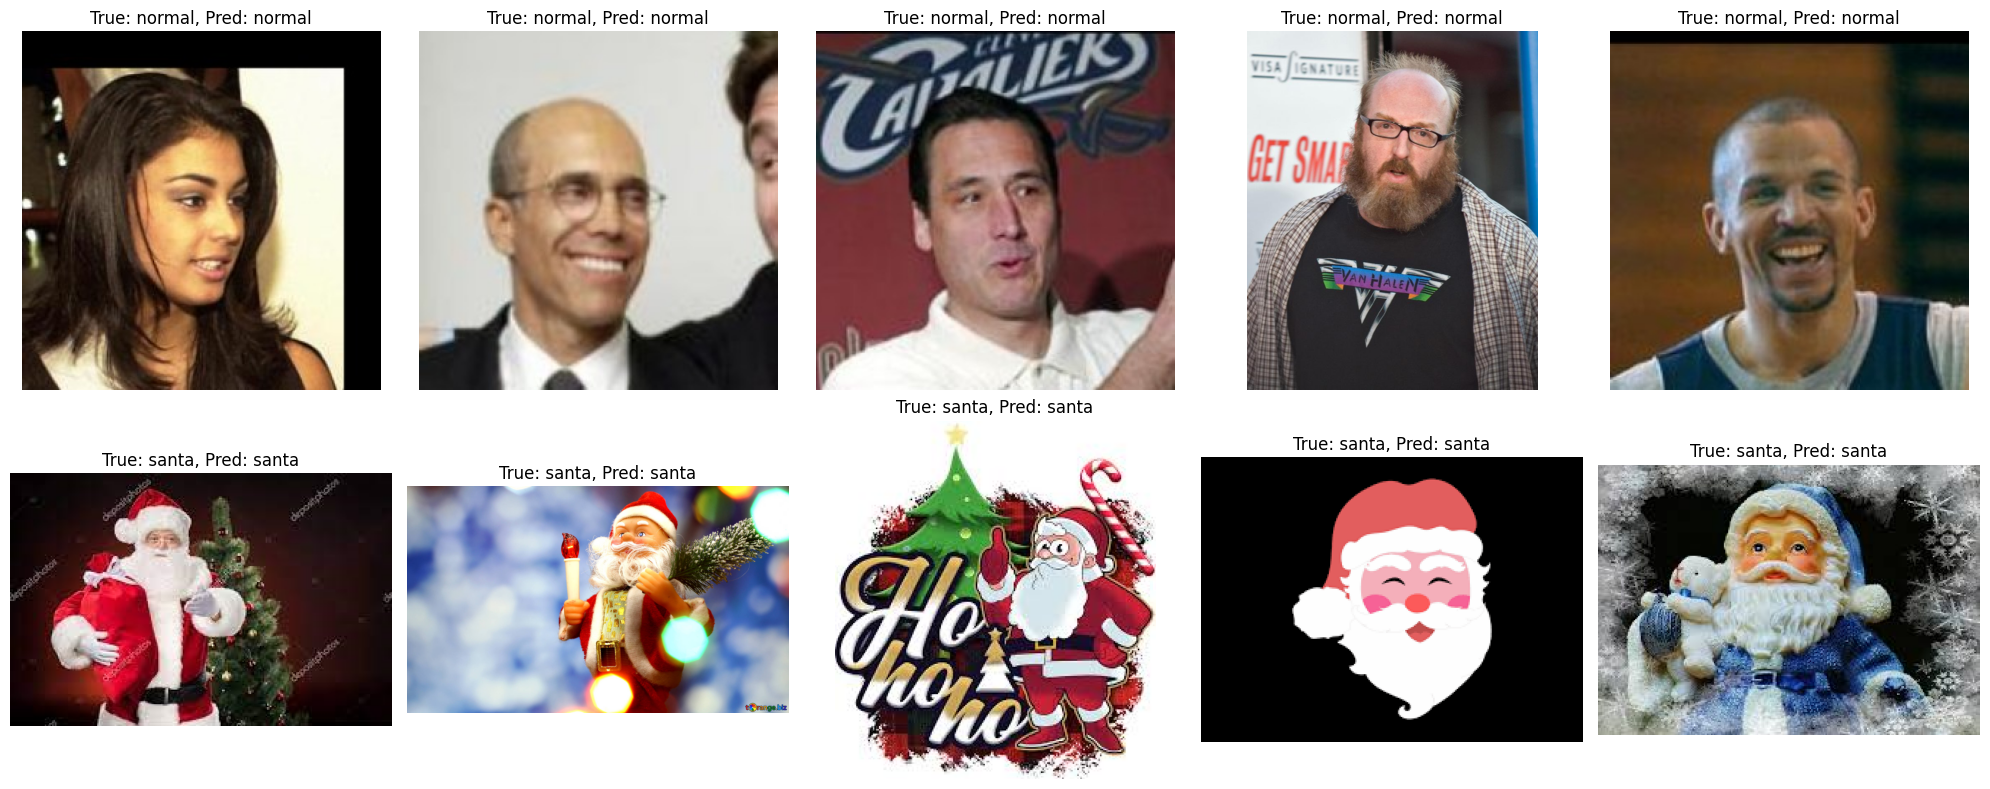

In [23]:
# 디바이스 설정 (GPU 사용 가능 여부 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)

        image = image.to(device)

        model.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = model(image)
            _, predicted = torch.max(outputs, 1)

        prediction = 'normal' if predicted.item() == 0 else 'santa'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

In [24]:
class VGG19_2(nn.Module):
    def __init__(self):
        super(VGG19_2, self).__init__()

        self.flatten = nn.Flatten()

        self.features = nn.Sequential(
            nn.Conv2d(3,64,kernel_size=(3, 3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(64,64,kernel_size=(3, 3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(64,128,kernel_size=(3, 3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(128,128,kernel_size=(3, 3),stride=(1,1),padding=(1,1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(7, 7))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=25088, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=2, bias=True)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.flatten(x)
        output = self.classifier(x)
        return output

In [25]:
model2 = VGG19_2().to(device)

In [29]:
train_losses_SGD2, val_losses_SGD2, val_accuracies_SGD2 = train_model('SGD', model2, train_loader, val_loader, criterion)

[SGD] Epoch 1/20 | Train Loss: 0.693128 | Val Loss: 0.693157 | Val Acc: 49.81% | Time: 24.09 sec
[SGD] Epoch 2/20 | Train Loss: 0.693050 | Val Loss: 0.693137 | Val Acc: 50.19% | Time: 22.78 sec
[SGD] Epoch 3/20 | Train Loss: 0.693164 | Val Loss: 0.693125 | Val Acc: 50.19% | Time: 21.68 sec
[SGD] Epoch 4/20 | Train Loss: 0.693131 | Val Loss: 0.693131 | Val Acc: 50.19% | Time: 22.29 sec
[SGD] Epoch 5/20 | Train Loss: 0.693230 | Val Loss: 0.693168 | Val Acc: 50.19% | Time: 23.72 sec
[SGD] Epoch 6/20 | Train Loss: 0.693234 | Val Loss: 0.693171 | Val Acc: 50.19% | Time: 21.44 sec
[SGD] Epoch 7/20 | Train Loss: 0.693187 | Val Loss: 0.693197 | Val Acc: 50.19% | Time: 22.62 sec
[SGD] Epoch 8/20 | Train Loss: 0.693271 | Val Loss: 0.693163 | Val Acc: 50.19% | Time: 21.78 sec
[SGD] Epoch 9/20 | Train Loss: 0.693165 | Val Loss: 0.692960 | Val Acc: 50.19% | Time: 23.15 sec
[SGD] Epoch 10/20 | Train Loss: 0.693213 | Val Loss: 0.693218 | Val Acc: 50.19% | Time: 23.00 sec
[SGD] Epoch 11/20 | Train Los

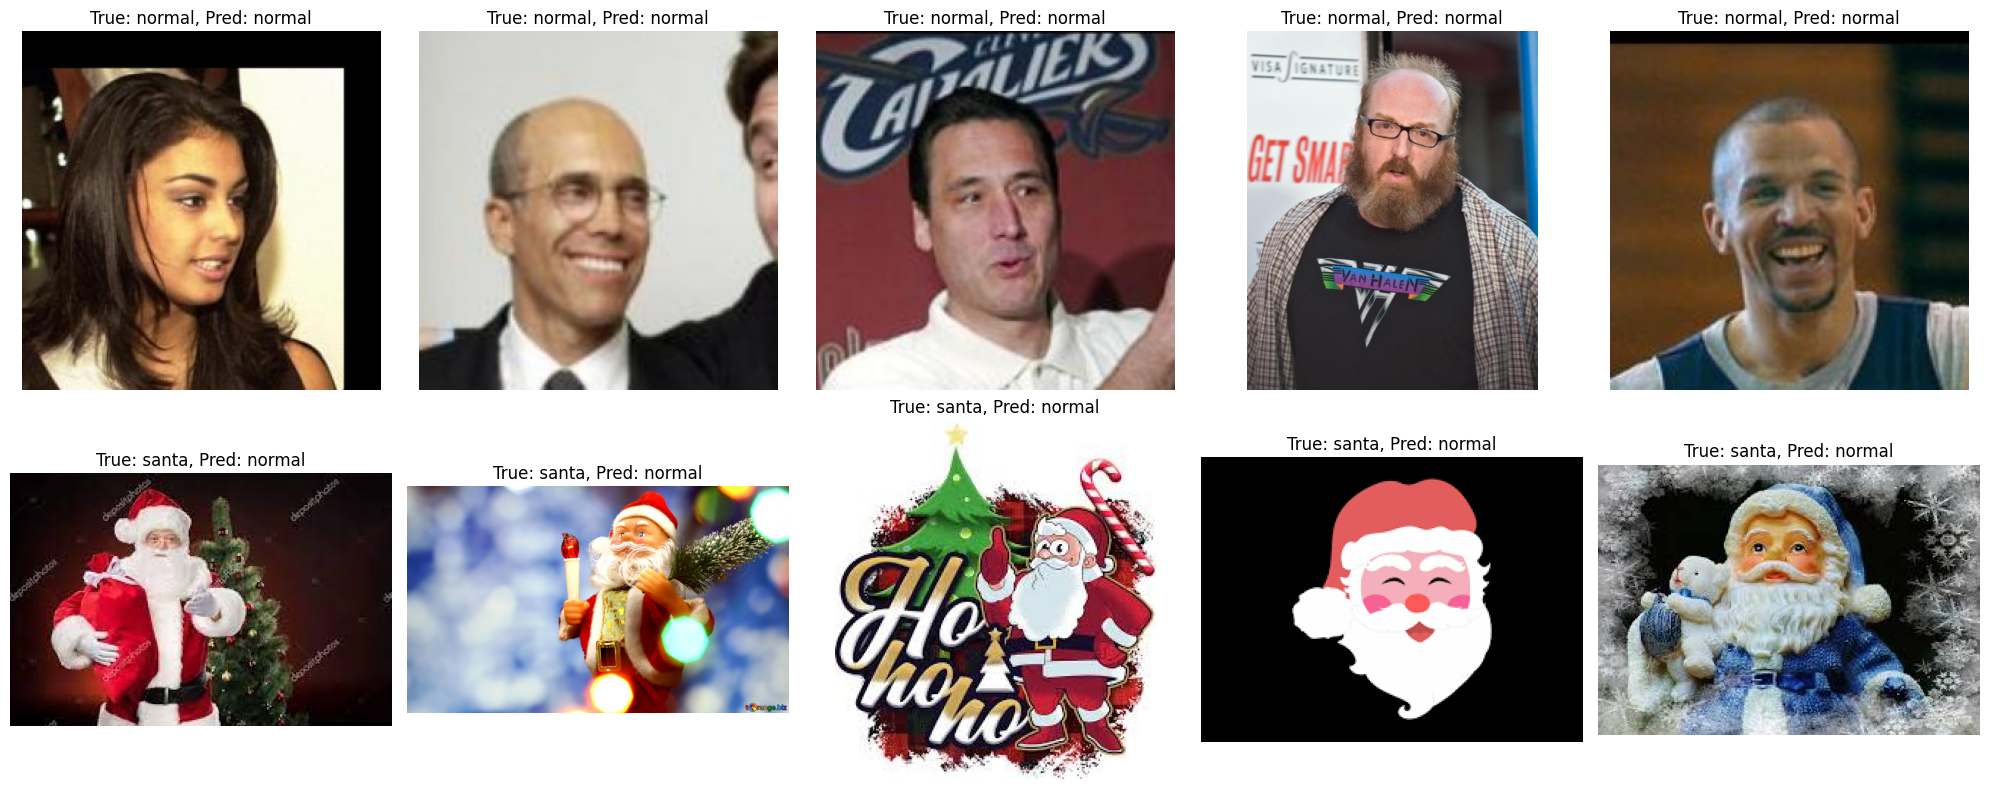

In [40]:
# 디바이스 설정 (GPU 사용 가능 여부 확인)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.figure(figsize=(20, 8))
# subplot 인덱스를 위한 카운터
counter = 1

# 각 클래스별로 5장의 이미지 추론 및 시각화
for class_name, folder_path in class_folders.items():
    # 해당 클래스의 이미지 경로 가져오기
    image_paths = glob.glob(os.path.join(folder_path, '*'))
    selected_paths = image_paths[:5]  # 첫 5장 선택

    for image_path in selected_paths:
        image = load_and_transform_image(image_path, transform)

        image = image.to(device)

        model2.eval()  # 모델을 평가 모드로 설정
        # 모델을 사용한 추론
        with torch.no_grad():
            outputs = model2(image)
            _, predicted = torch.max(outputs, 1)

        prediction = 'normal' if predicted.item() == 0 else 'santa'

        # 결과 시각화
        plt.subplot(2, 5, counter)
        plt.imshow(Image.open(image_path))
        plt.title(f'True: {class_name}, Pred: {prediction}')
        plt.axis('off')

        counter += 1  # subplot 인덱스 업데이트

plt.tight_layout()
plt.show()

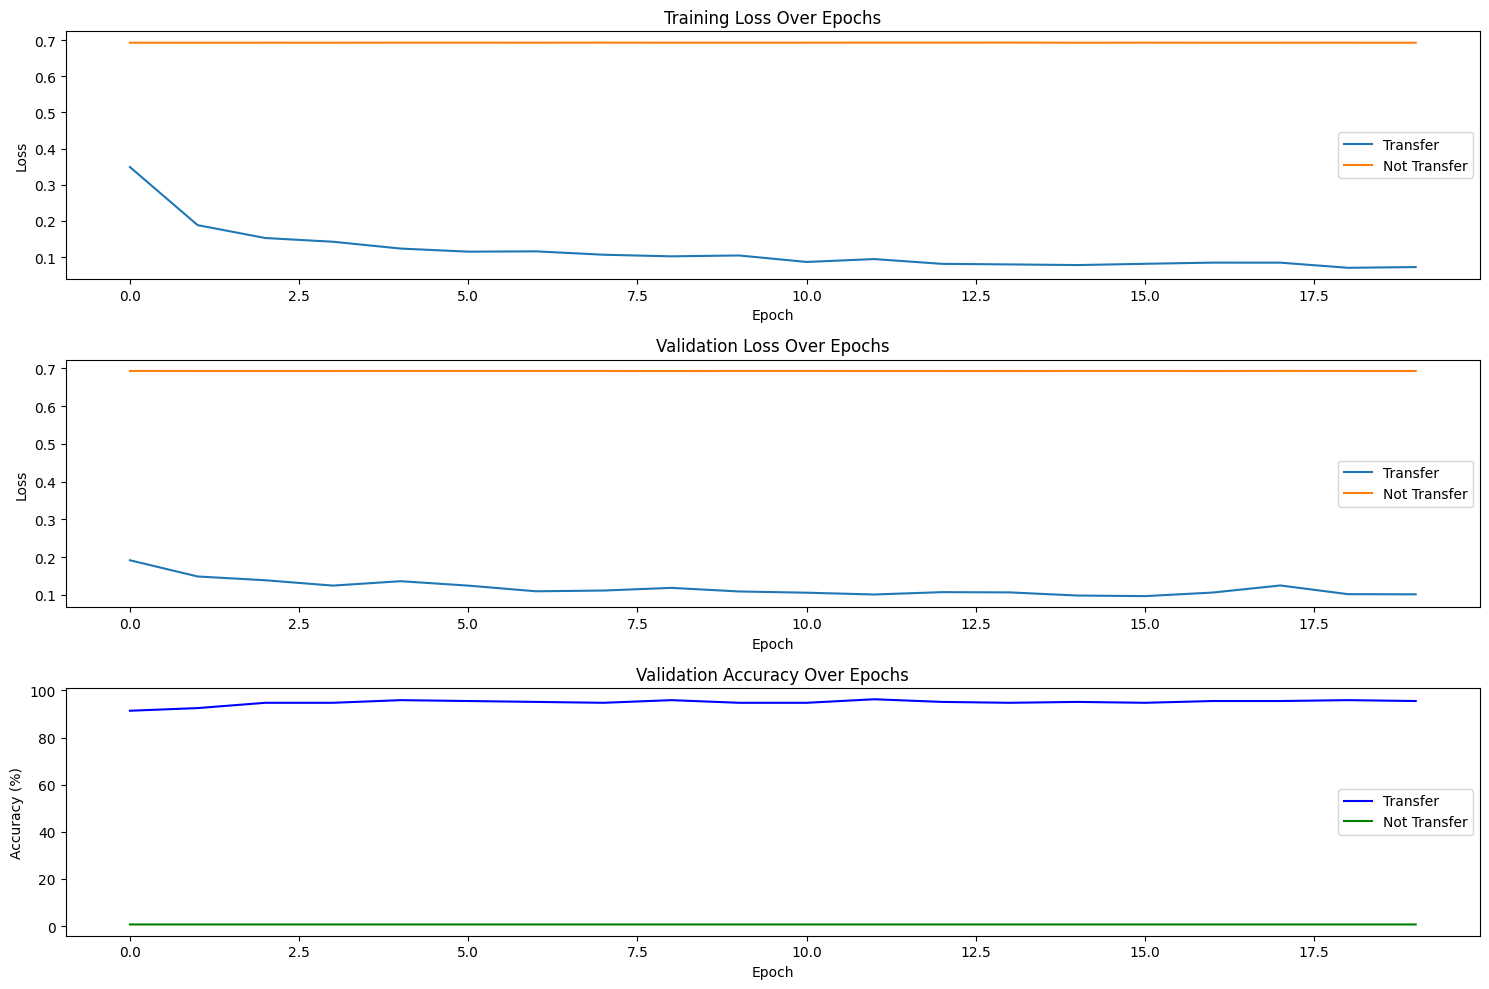

In [41]:
# 학습 손실과 검증 정확도 그래프 그리기
plt.figure(figsize=(15, 10))

# 학습 손실 그래프
plt.subplot(3, 1, 1)  # 3행 1열의 첫 번째 위치
plt.plot(train_losses_SGD, label='Transfer')
plt.plot(train_losses_SGD2, label='Not Transfer')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# 검증 손실 그래프
plt.subplot(3, 1, 2)  # 3행 1열의 두 번째 위치
plt.plot(val_losses_SGD, label='Transfer')
plt.plot(val_losses_SGD2, label='Not Transfer')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

# 검증 정확도 그래프
plt.subplot(3, 1, 3)  # 3행 1열의 세 번째 위치
plt.plot(val_accuracies_SGD, label='Transfer', color='blue')
plt.plot(val_losses_SGD2, label='Not Transfer', color='green')

plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()